In [1]:
#imports

import math
import multiprocessing
import pandas as pd
import numpy as np
import kagglehub
import seaborn as sns
import matplotlib.pyplot as plt
import re
import statsmodels.api as sm 
import scipy.stats as stats
import pylab as py 
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import spearmanr
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from kagglehub import KaggleDatasetAdapter
file_path = 'train-00000-of-00001.parquet'

# Download latest version
file_path = 'train-00000-of-00001.parquet'
path = kagglehub.dataset_download("sotirisbekiaris2/yelp-review-full-train")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/yelp-review-full-train


In [2]:
#load the train dataset df

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "sotirisbekiaris2/yelp-review-full-train",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)



#load the test dataset df_test

file_path_test = 'test-00000-of-00001.parquet'

df_test = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "sotirisbekiaris2/yelp-review-full-test",
  file_path_test,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df_test.head())
print(df_test.shape)


print("First 5 records:", df.head())


/tmp/ipykernel_31/677626765.py:3: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(
/tmp/ipykernel_31/677626765.py:19: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df_test = kagglehub.load_dataset(


First 5 records:    label                                               text
0      0  I got 'new' tires from them and within two wee...
1      0  Don't waste your time.  We had two different p...
2      0  All I can say is the worst! We were the only 2...
3      0  I have been to this restaurant twice and was d...
4      0  Food was NOT GOOD at all! My husband & I ate h...
(50000, 2)
First 5 records:    label                                               text
0      4  dr. goldberg offers everything i look for in a...
1      1  Unfortunately, the frustration of being Dr. Go...
2      3  Been going to Dr. Goldberg for over 10 years. ...
3      3  Got a letter in the mail last week that said D...
4      0  I don't know what Dr. Goldberg was like before...


In [4]:
print(df.head())
print(df.shape) #650000 x 2
print(df["label"].unique())
print(df["label"].value_counts())

   label                                               text
0      4  dr. goldberg offers everything i look for in a...
1      1  Unfortunately, the frustration of being Dr. Go...
2      3  Been going to Dr. Goldberg for over 10 years. ...
3      3  Got a letter in the mail last week that said D...
4      0  I don't know what Dr. Goldberg was like before...
(650000, 2)
[4 1 3 0 2]
label
4    130000
1    130000
3    130000
0    130000
2    130000
Name: count, dtype: int64


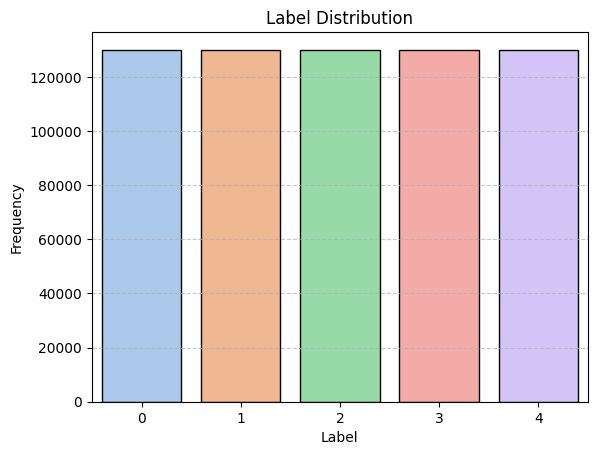

In [5]:
#check for class imbalance in label variable

sns.countplot(x="label", data=df, palette="pastel", edgecolor="black")
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [3]:
#Missing values checks before text
df[df.isnull().any(axis=1)] #null
df.isnull().sum().sum() #total number of missing values is 0




0

In [4]:
class_percentages = df["label"].value_counts(normalize=True).sort_index() * 100

print("Class Percentages (%):")
for label, pct in class_percentages.items():
    print(f"Label {label}: {pct:.2f}%")


Class Percentages (%):
Label 0: 20.00%
Label 1: 20.00%
Label 2: 20.00%
Label 3: 20.00%
Label 4: 20.00%


In [5]:
# Add word_count based on the original text
df["word_count"] = df["text"].astype(str).apply(lambda x: len(x.split()))


In [6]:
#function to clean text column
def clean_text(text):
    if pd.isna(text) or text.strip() == "":
        return np.nan  # replace empty/blank text with NaN
    text = re.sub(r'<.*?>', '', text)  # remove HTML tags
    text = re.sub(r"[^a-zA-Z' ]+", "", text)  # keep letters only
    text = text.lower()
    return text

# Apply cleaning
df["text"] = df["text"].apply(clean_text)


In [7]:
#rows with empty text:
df_empty_text = df[df["text"].isna() | (df["text"] == "")]
print(df_empty_text)


        label text  word_count
4587        0                1
51133       4                1
53114       0                1
59007       0                1
62578       0                1
78867       0                1
109441      4                1
146853      1                1
149228      2                1
193761      4                1
255219      4                1
294861      4                1
342769      3                1
342771      3                1
343281      0                1
366520      0                1
375693      0                1
398523      4                1
508062      2                1
553661      0                1
558002      4                1
559569      0                1
575920      0                1
595666      0                1
648191      4                1


In [8]:
print(df.loc[4588])
length = len(df.loc[4587, "text"]) if pd.notna(df.loc[4587, "text"]) else 0
print(length)

print(len(df.loc[4587, "text"]))


label                   3
text          i love pams
word_count              3
Name: 4588, dtype: object
0
0


In [8]:
# Drop rows with missing or empty cleaned text
df = df.dropna(subset=["text"])  # drop rows where cleaned text is NaN
df = df[df["text"].str.strip() != ""]  # drop rows where cleaned text is just spaces


In [9]:
print(df.shape)

(649973, 3)


In [12]:
print(max(df["word_count"]))

1052


In [10]:
#Missing values checks after replacing empty text with nan
df[df.isnull().any(axis=1)] #null
df.isnull().sum().sum() #total number of missing values is 27, that is to say that we had 27 empty texts
empty_text_df = df[df["text"].isna() | (df["text"].str.strip() == "")]
print(empty_text_df) #it seems that we cant understand user's intention from the label, so we are going to filter out those records
#27/65000 *100 = 0.041% the total number of missing values in the training set. So this action has a very minor impact in the dataset's information


Empty DataFrame
Columns: [label, text, word_count]
Index: []


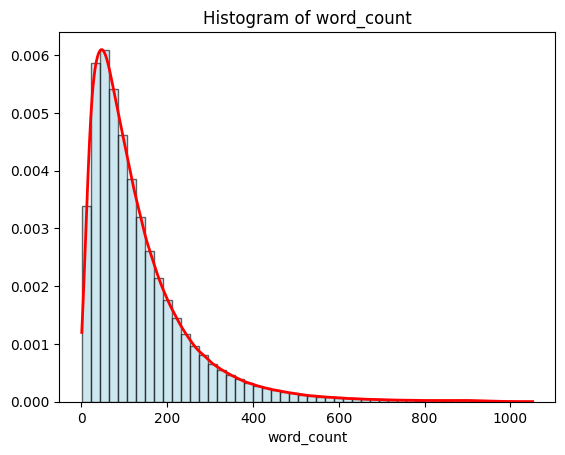

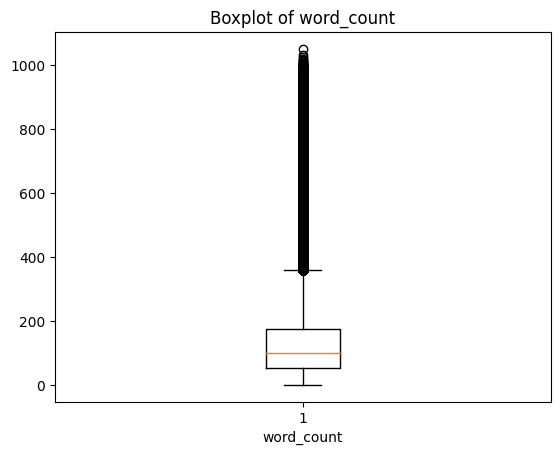

In [23]:
#histogram for word_count
from scipy.stats import gaussian_kde
plt.hist(df["word_count"], bins=50, density=True, alpha=0.6, color='lightblue', edgecolor='black')  #histogram of word_count variable indicates the need for log transformation
kde = gaussian_kde(df["word_count"])
x_vals = np.linspace(df["word_count"].min(), df["word_count"].max(), 1000)
plt.plot(x_vals, kde(x_vals), color='red', linewidth=2)
plt.title("Histogram of word_count")
plt.xlabel("word_count")
plt.show()


#boxplot for word_count
plt.boxplot(df["word_count"]) #boxplot indicates that there are too many outliers
plt.title("Boxplot of word_count")
plt.xlabel("word_count")
plt.show()



In [15]:
#statistics for word_count
print(df["word_count"].describe())

count    649973.000000
mean        134.103615
std         121.395608
min           1.000000
25%          52.000000
50%          99.000000
75%         175.000000
max        1052.000000
Name: word_count, dtype: float64


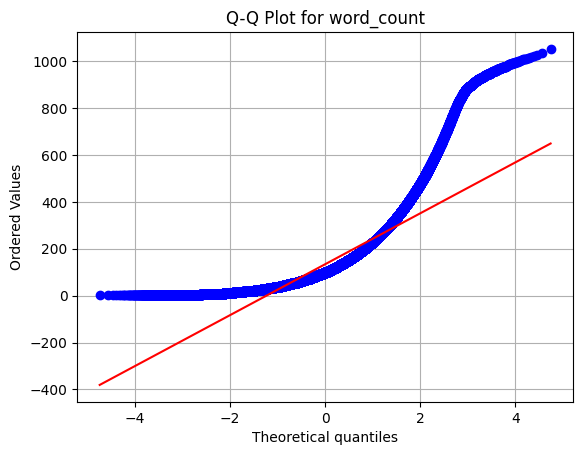

In [16]:
#qqplot for word_count in order to conduct Normality test
# Q-Q plot
stats.probplot(df["word_count"], dist="norm", plot=plt)
plt.title("Q-Q Plot for word_count")
plt.grid()
plt.show()

In [18]:
#D'Agostino Normality Test
#The null hypothesis is: H0: word_count follows Normal Dist versus H1: word_count does not follow Normal dist
from scipy.stats import normaltest

stat, p = normaltest(df["word_count"])

print(f"D'Agostino and Pearson test statistic = {stat:.4f}, p-value = {p:.4f}")
if p > 0.05:
    print("Word_count follows Normal Distribution.")
else:
    print("Word_count does not follow Normal Distribution.")

    

#As pval is equal to 0, we reject the null hypothesis at a significance level of alpha = 0.05

D'Agostino and Pearson test statistic = 309782.6182, p-value = 0.0000
Word_count does not follow Normal Distribution.


In [21]:
#natural logarithm transformation of word_count

log_word_count = np.log(df["word_count"])

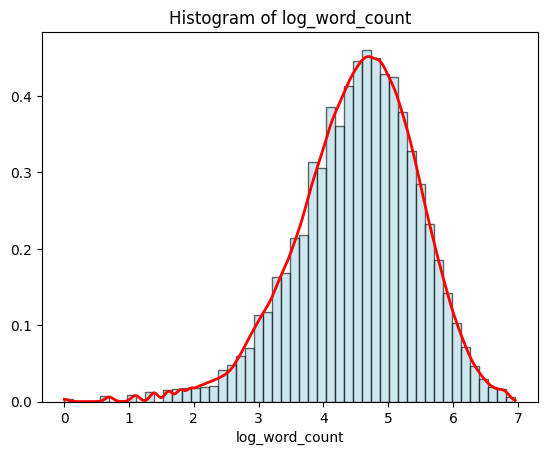

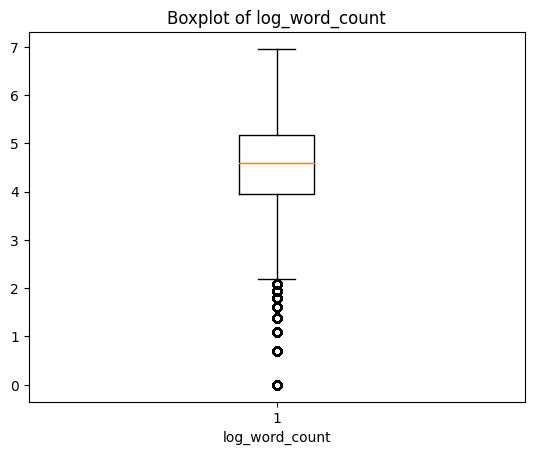

In [24]:
#same analysis with log transformation of word_count:
from scipy.stats import gaussian_kde


plt.hist(log_word_count, bins=50, density=True, alpha=0.6, color='lightblue', edgecolor='black')  #histogram of word_count variable indicates the need for log transformation
kde = gaussian_kde(log_word_count)
x_vals = np.linspace(log_word_count.min(), log_word_count.max(), 1000)
plt.plot(x_vals, kde(x_vals), color='red', linewidth=2)
plt.title("Histogram of log_word_count")
plt.xlabel("log_word_count")
plt.show()


#boxplot for word_count
plt.boxplot(log_word_count) #boxplot indicates that there are too many outliers
plt.title("Boxplot of log_word_count")
plt.xlabel("log_word_count")
plt.show()


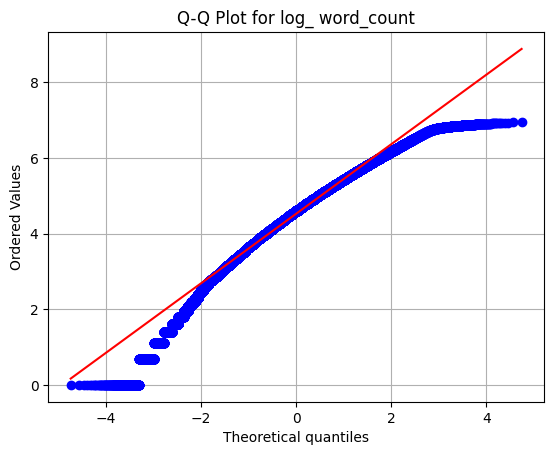

In [25]:
#qqplot for word_count in order to conduct Normality test
# Q-Q plot
stats.probplot(log_word_count, dist="norm", plot=plt)
plt.title("Q-Q Plot for log_ word_count")
plt.grid()
plt.show()


In [26]:
#D'Agostino Normality Test
#The null hypothesis is: H0: word_count follows Normal Dist versus H1: word_count does not follow Normal dist
from scipy.stats import normaltest

stat, p = normaltest(log_word_count)

print(f"D'Agostino and Pearson test statistic = {stat:.4f}, p-value = {p:.4f}")
if p > 0.05:
    print("Word_count follows Normal Distribution.")
else:
    print("Word_count does not follow Normal Distribution.")

    

#As pval is equal to 0, we reject the null hypothesis at a significance level of 95%

#Warning: the normality tests for large datasets(like this) are not as appropriate as qqplot 

D'Agostino and Pearson test statistic = 33817.0778, p-value = 0.0000
Word_count does not follow Normal Distribution.


In [27]:
from scipy.stats import skew, kurtosis

print("Skewness:", skew(log_word_count)) #skewness that approaches to 0 indicates for symmetric distribution
print("Kurtosis:", kurtosis(log_word_count)) #kurtosis that approaches to 0 indicates normal distribution(zero kurtosis)
#in our dataset, we have a sign of a normal distribution after

Skewness: -0.526067320882478
Kurtosis: 0.6872672497777552


In [28]:
#statistics for log_word_count
print(log_word_count.describe()) 
#as we can see, mean and 50%(median) are very similar, and that's an indication of Normal Distribution


count    649973.000000
mean          4.524270
std           0.925849
min           0.000000
25%           3.951244
50%           4.595120
75%           5.164786
max           6.958448
Name: word_count, dtype: float64


In [29]:
#outlier detection in log_word_count
from scipy.stats import zscore

#zscores
z_scores = zscore(log_word_count)

# outliers must be at the range Z-scores > 3 or < -3
outliers_z = log_word_count[np.abs(z_scores) > 3]
print(len(outliers_z))
print(f"Outliers based on Z-scores: {outliers_z}") #outliers lie in the range of [0, 1.60943]



4300
Outliers based on Z-scores: 18        1.098612
28        0.000000
337       0.000000
389       1.386294
457       0.000000
            ...   
645999    0.000000
646096    1.609438
646701    0.000000
647983    1.098612
648918    0.693147
Name: word_count, Length: 4300, dtype: float64


In [30]:
#replace outliers with median, in order not to break log_word_count's distribution

median_value = np.median(log_word_count)
log_word_count = np.where(log_word_count <= math.ceil(max(outliers_z)), median_value, log_word_count)



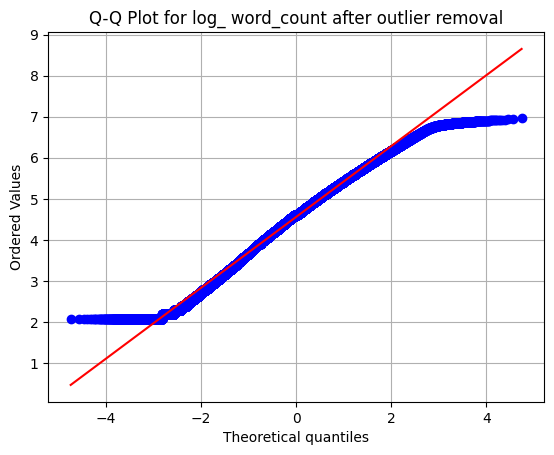

In [31]:
# Q-Q plot
stats.probplot(log_word_count, dist="norm", plot=plt)
plt.title("Q-Q Plot for log_ word_count after outlier removal")
plt.grid()
plt.show()


In [32]:
#add log_word_count to the df

df["log_word_count"] = log_word_count
print(df.shape)

(649973, 4)


In [33]:
#Kruskal-Wallis Normality test

from scipy.stats import kruskal

#create the groups
groups = [df[df["label"] == i]["log_word_count"] for i in range(5)]

#  Kruskal-Wallis H-test
stat, p = kruskal(*groups)

print(f"Kruskal-Wallis H-statistic: {stat}")
print(f"p-value: {p}")

#Null hypothesis is H0: median(log_word_count[0]) = ... = median(log_word_count[4])
#VS                H1: at least one of median(log_word_count[j]) is different, for j = 0,1,2,3,4

#since p-value = 0 we reject H0 (for alpha = 0.05) and thus we know that there are differences in the groups(but we do not know in which group-groups)

Kruskal-Wallis H-statistic: 17163.480214240568
p-value: 0.0


In [28]:
# #Dimensionality Reduction

# df['tokens'] = df['text'].apply(lambda x: x.lower().split())

# #train word2Vec
# model = Word2Vec(sentences=df['tokens'], vector_size=50, window=5, min_count=5, workers=4)

# #get the average embeddings in each  document
# def get_avg_vector(tokens, model):
#     vectors = [model.wv[word] for word in tokens if word in model.wv]
#     if vectors:
#         return np.mean(vectors, axis=0)
#     else:
#         return np.zeros(model.vector_size)

# #embedding matrix
# embeddings = np.array([get_avg_vector(tokens, model) for tokens in df['tokens']])



In [34]:
#Dimensionality Reduction

#alternative embeddings creation with more optimized way
#TODO remove the above after test

# Vectorized tokenization
df['tokens'] = df['text'].str.lower().str.split()

# Word2Vec training
cores = multiprocessing.cpu_count()
model = Word2Vec(
    sentences=df['tokens'].tolist(),
    vector_size=50,
    window=5,
    min_count=5,
    workers=cores,
    epochs=5      # μείωσε/αύξησε αν χρειάζεται
)


wv = model.wv

embeddings = np.stack([wv.get_mean_vector(tokens) for tokens in df['tokens']])


In [35]:
#PCA
pca = PCA(n_components=2) #PC1 and PC2
text_vectors_pca = pca.fit_transform(embeddings)

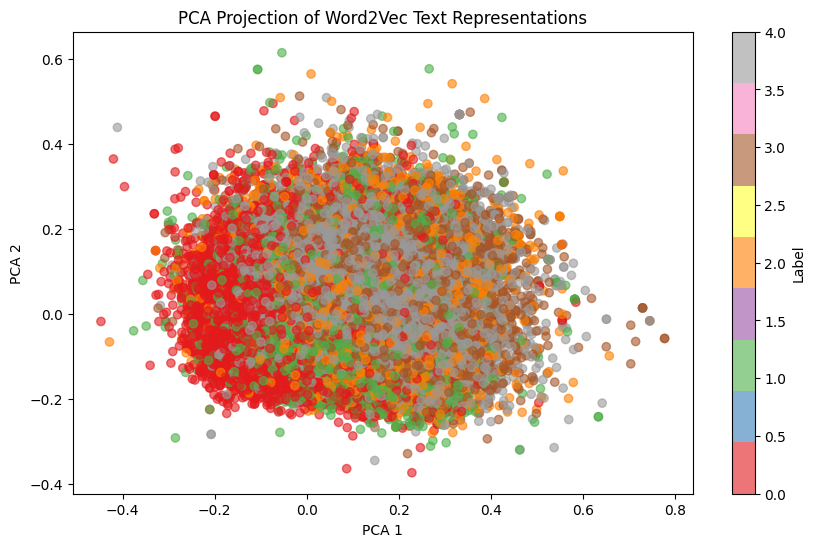

In [36]:
#visualize principal components
plt.figure(figsize=(10,6))
scatter = plt.scatter(text_vectors_pca[:, 0], text_vectors_pca[:, 1], c=df["label"], cmap="Set1", alpha=0.6)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA Projection of Word2Vec Text Representations")
plt.colorbar(scatter, label="Label")
plt.show()

In [23]:
explained_var = pca.explained_variance_ratio_
print("Explained variance by PC1 + PC2: ", explained_var[:2].sum())
#That means that the total variation explained by PC1 and PC2 is 36.26%, which is low

Explained variance by PC1 + PC2:  0.3370980207783203


In [37]:
#ordinal_word_count

#create threshold using quantile function
low_thresh = df["word_count"].quantile(0.33)
high_thresh = df["word_count"].quantile(0.66)

ordinal_mapping = {"Low": 0, "Medium": 1, "High": 2} #map each category with a number in order to conduct Spearman

#create the categorization
def categorize_word_count(x):
    if x <= low_thresh:
        return "Low"
    elif x <= high_thresh:
        return "Medium"
    else:
        return "High"

#add ordinal column in the df
df["ordinal_word_count"] = df["word_count"].apply(categorize_word_count)
df["ordinal_word_count_encoded"] = df["ordinal_word_count"].map(ordinal_mapping)


In [38]:
spearman_corr, p_value = spearmanr(df["ordinal_word_count_encoded"], df["label"])

print(f"Spearman correlation coefficient: {spearman_corr}")
print(f"P-value: {p_value}")

#Negative spearman r = -0.133 means that as label decreases, the word_count increases, which is what we wanted, as the lower the label, the greater the review(text)

Spearman correlation coefficient: -0.1345899951983679
P-value: 0.0


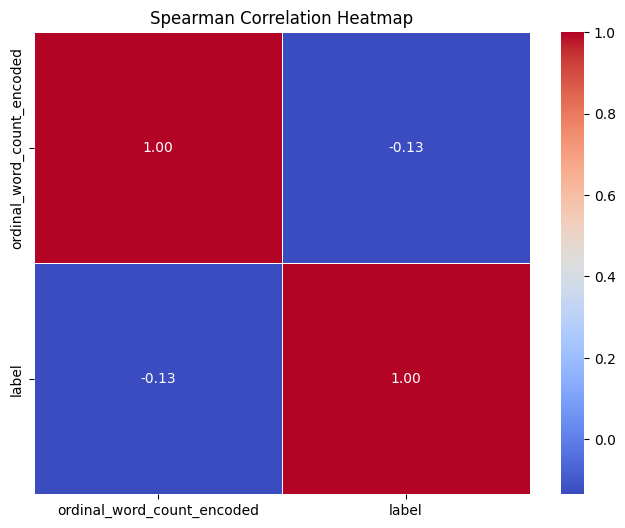

In [39]:
#heatmap
corr_matrix = df[["ordinal_word_count_encoded", "label"]].corr(method="spearman")

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Spearman Correlation Heatmap")
plt.show()

In [40]:
#Classification techniques - train and validation split

X = np.hstack((embeddings, df[['log_word_count']].values)) #construction of predictor matirx
y = df['label'].values #response variable(our y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) #split the test using sklearn train_test_split in 80% train and 20% validation





In [41]:
# standardization for faster computations

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [42]:
#Multinomial Regression - Model fit

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import numpy as np


# fit multinomial logistic regression
log_reg = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=2000,
    random_state=42
)
log_reg.fit(X_train_scaled, y_train)

# prediction
y_pred = log_reg.predict(X_val_scaled)

# model evaluation
print("Accuracy:", accuracy_score(y_val, y_pred)) #accuracy is 51.29% 
print(classification_report(y_val, y_pred, digits=4)) 
#average: precision 50.82%, recall 51.29%, f1-score 50.99% (macro avg is the average metric of each class)


Accuracy: 0.5145505596369091
              precision    recall  f1-score   support

           0     0.6229    0.7009    0.6596     25997
           1     0.4431    0.4317    0.4373     26000
           2     0.4210    0.4146    0.4178     26000
           3     0.4507    0.4135    0.4313     26000
           4     0.6131    0.6120    0.6126     25998

    accuracy                         0.5146    129995
   macro avg     0.5102    0.5146    0.5117    129995
weighted avg     0.5102    0.5146    0.5117    129995



In [43]:
#evaluation metrics for Multinomial Regression

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
import numpy as np


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000, random_state=42))
])

# hyperparameter optimization with grid search
param_grid = {
    'log_reg__C': [0.01, 0.1, 1, 10],
    'log_reg__penalty': ['l2']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

# best model
best_model = grid_search.best_estimator_

# predictions
y_pred = best_model.predict(X_val)

# model evaluation
print("\nAccuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred, digits=4))

# ROC-AUC
y_proba = best_model.predict_proba(X_val)
roc_auc = roc_auc_score(y_val, y_proba, multi_class='ovr', average='macro')
print("\nMacro ROC-AUC:", roc_auc) #ROC-AUC 82.38%


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters: {'log_reg__C': 10, 'log_reg__penalty': 'l2'}

Accuracy: 0.5145582522404708

Classification Report:
               precision    recall  f1-score   support

           0     0.6230    0.7009    0.6596     25997
           1     0.4431    0.4318    0.4374     26000
           2     0.4210    0.4146    0.4178     26000
           3     0.4506    0.4135    0.4313     26000
           4     0.6131    0.6120    0.6126     25998

    accuracy                         0.5146    129995
   macro avg     0.5102    0.5146    0.5117    129995
weighted avg     0.5102    0.5146    0.5117    129995


Macro ROC-AUC: 0.8248896561809735


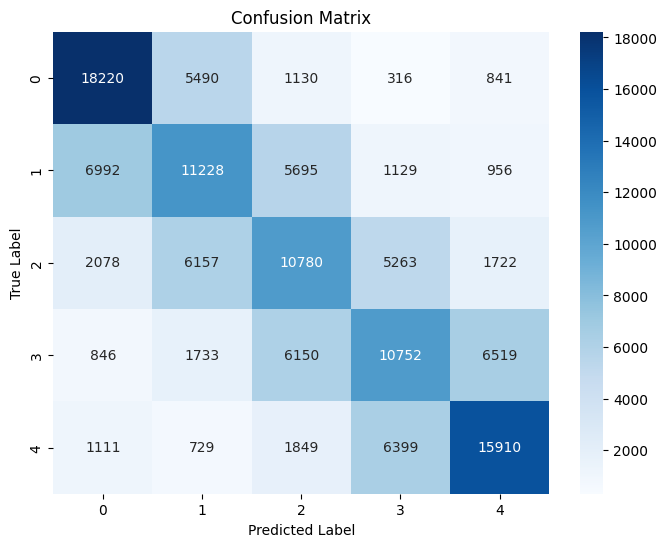

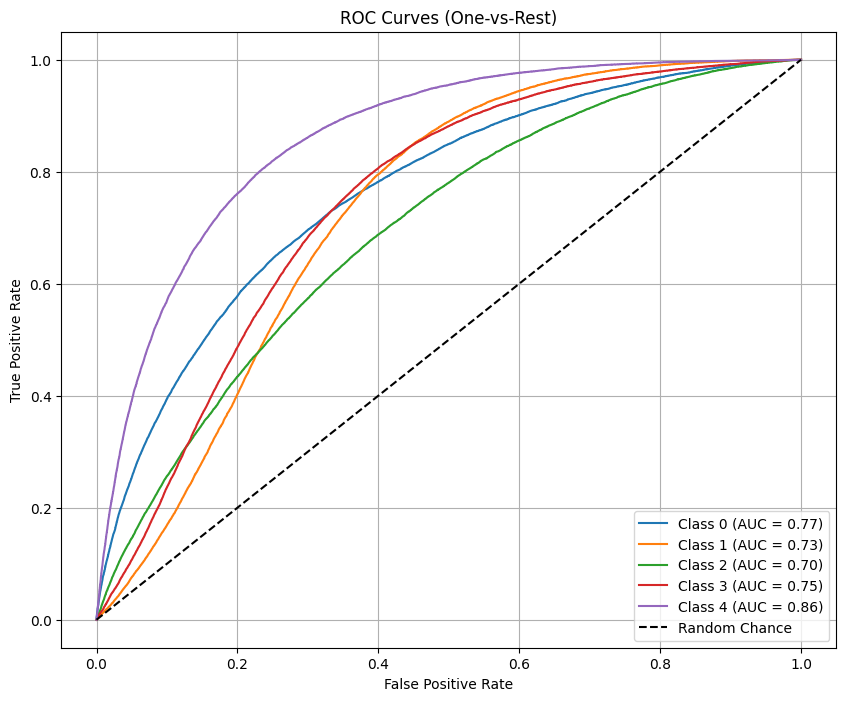

In [44]:
#Confusion matrix and ROC curve for Multinomial Regression

from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay

# --- Confusion Matrix ---
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
y_proba = log_reg.predict_proba(X_val)

# Binarize labels (0-4)
y_val_bin = label_binarize(y_val, classes=[0, 1, 2, 3, 4])

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_val_bin.shape[1]

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [31]:
#Naive Bayes
print(np.any(X_train_scaled < 0)) #we have negative values due to the standardization, so we will use gaussian naive bayes

True


In [45]:
#Naive Bayes fit
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# model fit
gnb_model = GaussianNB()
gnb_model.fit(X_train_scaled, y_train)

# model prediction
y_pred_gnb = gnb_model.predict(X_val_scaled)

# model accuracy
print("Accuracy:", accuracy_score(y_val, y_pred_gnb))
print(classification_report(y_val, y_pred_gnb)) #Accuracy 38.01% 

#average: precision 39%, recall 38%, f1-score 38%

Accuracy: 0.38419169968075695
              precision    recall  f1-score   support

           0       0.49      0.62      0.55     25997
           1       0.29      0.47      0.36     26000
           2       0.32      0.26      0.29     26000
           3       0.38      0.24      0.30     26000
           4       0.48      0.33      0.39     25998

    accuracy                           0.38    129995
   macro avg       0.39      0.38      0.38    129995
weighted avg       0.39      0.38      0.38    129995



In [46]:
#Naive Bayes evaluation metrics

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

# GridSearch 3-fold cross-validation
grid_search = GridSearchCV(GaussianNB(), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# best hyperparamters
print("Best Params:", grid_search.best_params_)


gnb_best = grid_search.best_estimator_


Best Params: {'var_smoothing': 1e-09}


In [47]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize

y_pred = gnb_best.predict(X_val_scaled)
y_prob = gnb_best.predict_proba(X_val_scaled)

#Accuracy + classification report
print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

#ROC-AUC
y_val_binarized = label_binarize(y_val, classes=[0, 1, 2, 3, 4])
roc_auc = roc_auc_score(y_val_binarized, y_prob, average="macro", multi_class="ovr")
print("ROC AUC Score (macro):", roc_auc)

#AUC-ROC 71.44%

Accuracy: 0.38419169968075695
              precision    recall  f1-score   support

           0       0.49      0.62      0.55     25997
           1       0.29      0.47      0.36     26000
           2       0.32      0.26      0.29     26000
           3       0.38      0.24      0.30     26000
           4       0.48      0.33      0.39     25998

    accuracy                           0.38    129995
   macro avg       0.39      0.38      0.38    129995
weighted avg       0.39      0.38      0.38    129995

ROC AUC Score (macro): 0.7163627199473878


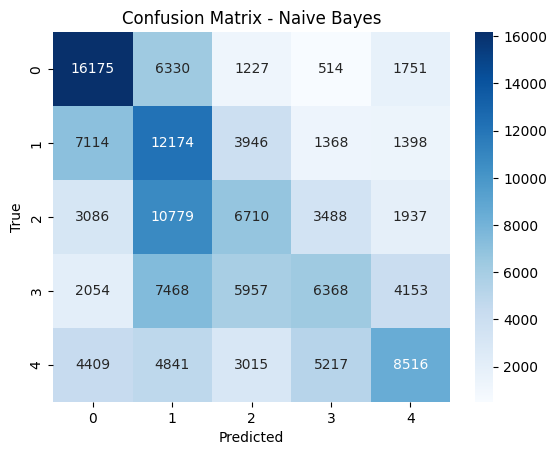

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Naive Bayes")
plt.show()


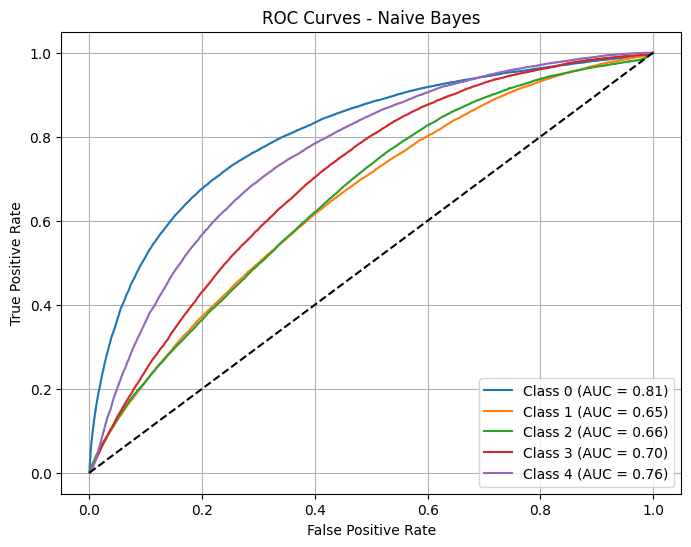

In [49]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 5

# FPR, TPR for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC Curve plots
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
    
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Naive Bayes")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [50]:
#K Nearest Neighbor

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time

#record time(initialization)
start_time = time.time()

#model initialization
knn = KNeighborsClassifier(n_neighbors=5)  # default = 5

#model training
knn.fit(X_train_scaled, y_train)

#prediction
y_pred_knn = knn.predict(X_val_scaled)

#record how long this model lasted 
print("Execution time:", time.time() - start_time)


print("Accuracy:", accuracy_score(y_val, y_pred_knn))
print("\nClassification Report:\n", classification_report(y_val, y_pred_knn)) #Accuracy 43.09%

#average: precision 44%, recall 43%, f1-score 43%


Execution time: 202.71095633506775
Accuracy: 0.4322550867341052

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.63      0.59     25997
           1       0.35      0.39      0.37     26000
           2       0.33      0.35      0.34     26000
           3       0.37      0.34      0.36     26000
           4       0.59      0.45      0.51     25998

    accuracy                           0.43    129995
   macro avg       0.44      0.43      0.43    129995
weighted avg       0.44      0.43      0.43    129995



In [51]:
#KNN evaluation metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score

# subsampling of 10% of the initial dataset in order to work faster with the algorithm fit
X_train_sub, _, y_train_sub, _ = train_test_split(
    X_train_scaled, y_train, test_size=0.9, stratify=y_train, random_state=42
)

# grid params
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# GridSearchCV
grid_search = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=3,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1
)

#subsampling training
grid_search.fit(X_train_sub, y_train_sub)

#best parameters
print("Best Params from 10% training data:", grid_search.best_params_)


#best model
best_knn = KNeighborsClassifier(**grid_search.best_params_)
best_knn.fit(X_train_scaled, y_train)

#validation set prediction
y_pred_knn_opt = best_knn.predict(X_val_scaled)
y_prob = best_knn.predict_proba(X_val_scaled)

#metrics
print("Accuracy:", accuracy_score(y_val, y_pred_knn_opt))
print("F1 Score (macro):", f1_score(y_val, y_pred_knn_opt, average='macro'))
print("\nClassification Report:\n", classification_report(y_val, y_pred_knn_opt)) #accuracy: 44.28% with 10% of the dataset
roc_auc_macro = roc_auc_score(y_val_bin, y_prob, average='macro', multi_class='ovr')
print("ROC-AUC Score (macro):", roc_auc_macro) 


#Average precision: 45%, recall: 44%, f1-score: 44%
#AUC-ROC 75.30%

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Params from 10% training data: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
Accuracy: 0.4429324204777107
F1 Score (macro): 0.4447269581266414

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.58      0.59     25997
           1       0.37      0.37      0.37     26000
           2       0.34      0.36      0.35     26000
           3       0.36      0.37      0.37     26000
           4       0.56      0.53      0.54     25998

    accuracy                           0.44    129995
   macro avg       0.45      0.44      0.44    129995
weighted avg       0.45      0.44      0.44    129995

ROC-AUC Score (macro): 0.7533777167553135


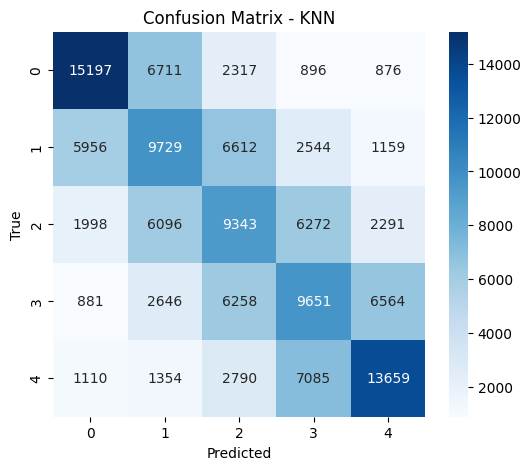

In [52]:
# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix



cm = confusion_matrix(y_val, y_pred_knn_opt)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - KNN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


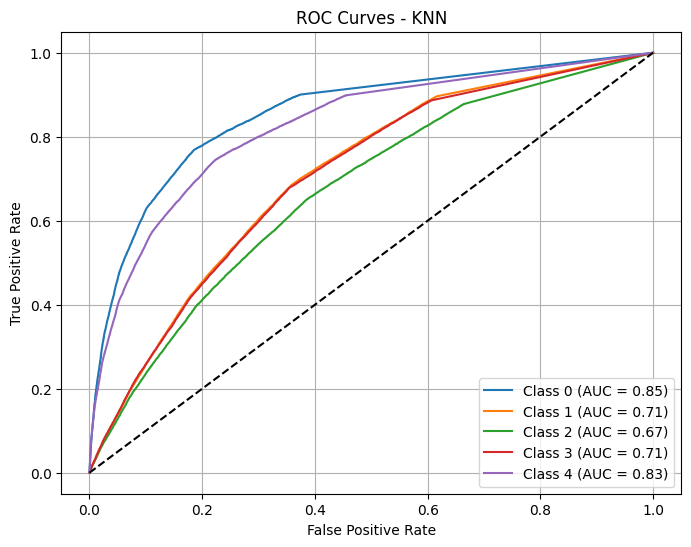

In [53]:
#ROC Curve

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#label binarize
y_val_binarized = label_binarize(y_val, classes=[0, 1, 2, 3, 4])

y_prob = best_knn.predict_proba(X_val_scaled)

# TPR, FPR, AUC per class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 5

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Roc curve plot
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - KNN")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [54]:
#SVM
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

#fit
svm_clf = LinearSVC(random_state=42, max_iter=5000, dual=False, tol=1e-3)
svm_clf.fit(X_train_scaled, y_train)

#prediction
y_pred_svm = svm_clf.predict(X_val_scaled)

#evaluation
print("Accuracy:", accuracy_score(y_val, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_val, y_pred_svm)) #Accuracy 50%

#Average: precision 49%, recall 50%, f1-score 49%

Accuracy: 0.5037039886149467

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.79      0.65     25997
           1       0.45      0.33      0.38     26000
           2       0.43      0.37      0.40     26000
           3       0.45      0.34      0.39     26000
           4       0.56      0.69      0.62     25998

    accuracy                           0.50    129995
   macro avg       0.49      0.50      0.49    129995
weighted avg       0.49      0.50      0.49    129995



In [55]:
#SVM evaluation metrics
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score


param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'tol': [1e-4, 1e-3],
    'max_iter': [3000, 5000],
}

svc = LinearSVC(dual=False, random_state=42)

#grid- search 3 fold cross validation
grid_search = GridSearchCV(
    svc, param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)


# Retrain with best params
best_svc = LinearSVC(**grid_search.best_params_, dual=False, random_state=42)
best_svc.fit(X_train_scaled, y_train)
y_pred = best_svc.predict(X_val_scaled)

#metrics
print("Accuracy:", accuracy_score(y_val, y_pred))
print("F1 Score (macro):", f1_score(y_val, y_pred, average='macro'))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

# Binarize y_val
y_val_bin = label_binarize(y_val, classes=np.unique(y_val))

# decision_function instead of predictor_proba
y_scores = best_svc.decision_function(X_val_scaled)

# ROC AUC macro
roc_auc = roc_auc_score(y_val_bin, y_scores, average='macro', multi_class='ovr')
print("ROC AUC (macro):", roc_auc)

#Average ROC-AUC Score: 80.36%


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters: {'C': 1, 'max_iter': 3000, 'tol': 0.0001}
Accuracy: 0.5036809108042617
F1 Score (macro): 0.4867550872318578

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.79      0.65     25997
           1       0.45      0.33      0.38     26000
           2       0.43      0.37      0.40     26000
           3       0.45      0.34      0.39     26000
           4       0.56      0.69      0.62     25998

    accuracy                           0.50    129995
   macro avg       0.49      0.50      0.49    129995
weighted avg       0.49      0.50      0.49    129995

ROC AUC (macro): 0.804367036630359


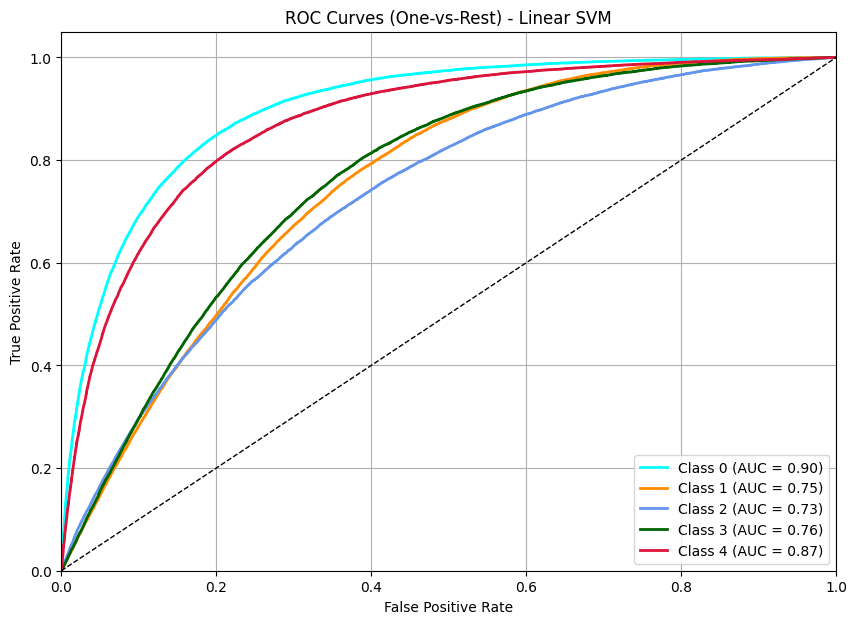

In [56]:
#ROC Curve Plot

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

# Binarize the labels
classes = np.unique(y_val)
y_val_bin = label_binarize(y_val, classes=classes)
n_classes = y_val_bin.shape[1]

# Get decision scores
y_score = best_svc.decision_function(X_val_scaled)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 7))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'crimson'])

for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i], tpr[i], color=color, lw=2,
        label=f'Class {classes[i]} (AUC = {roc_auc[i]:0.2f})'
    )

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest) - Linear SVM')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [57]:
#Neural Networks and Deep Learning

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

Epoch 1/10 - Train Loss: 1.1048 - Val Loss: 1.0840
Epoch 2/10 - Train Loss: 1.0845 - Val Loss: 1.0781
Epoch 3/10 - Train Loss: 1.0803 - Val Loss: 1.0785
Epoch 4/10 - Train Loss: 1.0771 - Val Loss: 1.0793
Epoch 5/10 - Train Loss: 1.0751 - Val Loss: 1.0733
Epoch 6/10 - Train Loss: 1.0738 - Val Loss: 1.0736
Epoch 7/10 - Train Loss: 1.0725 - Val Loss: 1.0725
Epoch 8/10 - Train Loss: 1.0713 - Val Loss: 1.0737
Epoch 9/10 - Train Loss: 1.0707 - Val Loss: 1.0695
Epoch 10/10 - Train Loss: 1.0700 - Val Loss: 1.0712


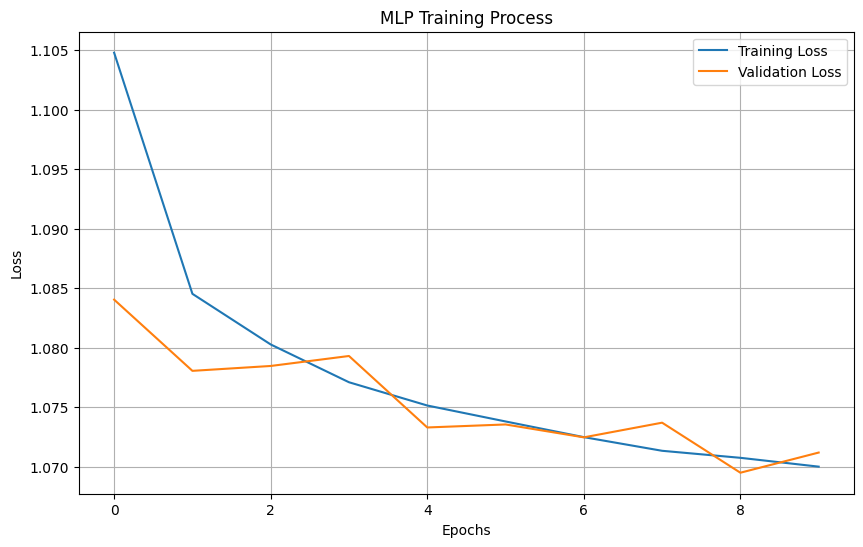

Accuracy: 0.5312127389514981

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.71      0.68     25997
           1       0.45      0.50      0.47     26000
           2       0.45      0.38      0.41     26000
           3       0.45      0.46      0.46     26000
           4       0.65      0.61      0.63     25998

    accuracy                           0.53    129995
   macro avg       0.53      0.53      0.53    129995
weighted avg       0.53      0.53      0.53    129995



In [58]:
# MLP Model (2 layers, ReLU, 0.001 LR)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

#model initialization
input_dim = X_train_scaled.shape[1]
hidden_dim = 64
output_dim = 5

model = MLP(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 10
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * xb.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for xb_val, yb_val in val_loader:
            val_preds = model(xb_val)
            val_loss = criterion(val_preds, yb_val)
            running_val_loss += val_loss.item() * xb_val.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")

#learning curves plot
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MLP Training Process')
plt.legend()
plt.grid()
plt.show()

#model eval
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_val_tensor)
    y_pred = torch.argmax(y_pred_probs, dim=1)

print("Accuracy:", accuracy_score(y_val, y_pred.numpy()))
print("\nClassification Report:\n", classification_report(y_val, y_pred.numpy()))

#MLP model has 2 layers, 64 hidden layers, 0.001 learning rate and ReLU activation function

#Accuracy 53.01%

#Average: precision 52%, recall 53%, f1-score 53%

Epoch 1/10 - Train Loss: 1.1000 - Val Loss: 1.0759
Epoch 2/10 - Train Loss: 1.0723 - Val Loss: 1.0676
Epoch 3/10 - Train Loss: 1.0647 - Val Loss: 1.0632
Epoch 4/10 - Train Loss: 1.0601 - Val Loss: 1.0588
Epoch 5/10 - Train Loss: 1.0570 - Val Loss: 1.0591
Epoch 6/10 - Train Loss: 1.0542 - Val Loss: 1.0576
Epoch 7/10 - Train Loss: 1.0517 - Val Loss: 1.0570
Epoch 8/10 - Train Loss: 1.0499 - Val Loss: 1.0566
Epoch 9/10 - Train Loss: 1.0481 - Val Loss: 1.0603
Epoch 10/10 - Train Loss: 1.0469 - Val Loss: 1.0595


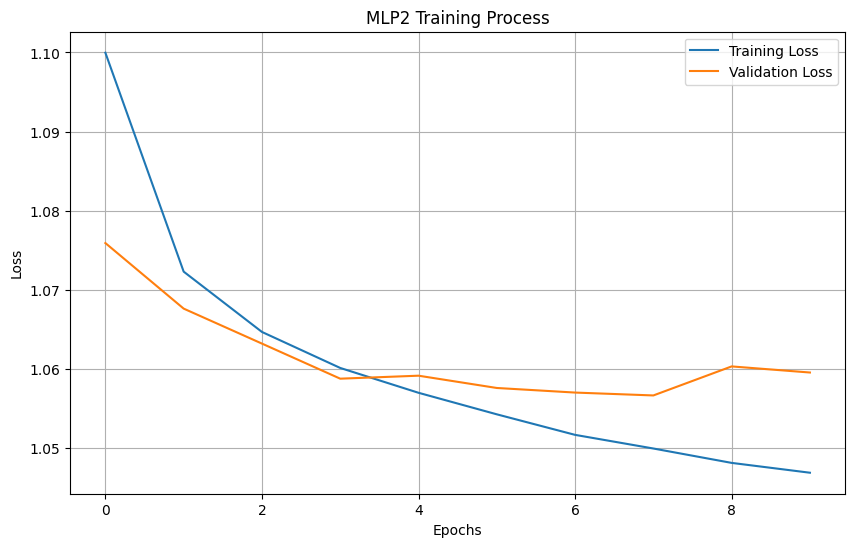

Accuracy: 0.5346821031578137

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.67      0.68     25997
           1       0.46      0.50      0.48     26000
           2       0.44      0.45      0.44     26000
           3       0.46      0.42      0.44     26000
           4       0.64      0.64      0.64     25998

    accuracy                           0.53    129995
   macro avg       0.54      0.53      0.53    129995
weighted avg       0.54      0.53      0.53    129995



In [59]:
# MLP2 Model (3 layers and ReLU, 0.0005 LR)
class MLP2(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP2, self).__init__()
        self.model = nn.Sequential(
    nn.Linear(input_dim, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, output_dim)
)

    def forward(self, x):
        return self.model(x)

#model initialization
input_dim = X_train_scaled.shape[1]
output_dim = 5

model2 = MLP2(input_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.0005)


# Training Loop
epochs = 10
train_losses_mlp2 = []
val_losses_mlp2 = []

for epoch in range(epochs):
    model2.train()
    running_train_loss = 0.0
    for xb, yb in train_loader:
        optimizer2.zero_grad()
        preds = model2(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer2.step()
        running_train_loss += loss.item() * xb.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses_mlp2.append(epoch_train_loss)

    model2.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for xb_val, yb_val in val_loader:
            val_preds = model2(xb_val)
            val_loss = criterion(val_preds, yb_val)
            running_val_loss += val_loss.item() * xb_val.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses_mlp2.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")

# Μετά το training, plot:
plt.figure(figsize=(10,6))
plt.plot(train_losses_mlp2, label='Training Loss')
plt.plot(val_losses_mlp2, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MLP2 Training Process')
plt.legend()
plt.grid()
plt.show()

#model evaluation
model2.eval()
with torch.no_grad():
    y_pred_probs = model2(X_val_tensor)
    y_pred = torch.argmax(y_pred_probs, dim=1)

print("Accuracy:", accuracy_score(y_val, y_pred.numpy()))
print("\nClassification Report:\n", classification_report(y_val, y_pred.numpy()))


#Accuracy 53.46%

#Average: precision 53%, recall 53%, f1-score 53%

Epoch 1/10 - Train Loss: 1.0993 - Val Loss: 1.0721
Epoch 2/10 - Train Loss: 1.0719 - Val Loss: 1.0690
Epoch 3/10 - Train Loss: 1.0644 - Val Loss: 1.0626
Epoch 4/10 - Train Loss: 1.0602 - Val Loss: 1.0624
Epoch 5/10 - Train Loss: 1.0569 - Val Loss: 1.0595
Epoch 6/10 - Train Loss: 1.0541 - Val Loss: 1.0602
Epoch 7/10 - Train Loss: 1.0515 - Val Loss: 1.0579
Epoch 8/10 - Train Loss: 1.0497 - Val Loss: 1.0567
Epoch 9/10 - Train Loss: 1.0481 - Val Loss: 1.0578
Epoch 10/10 - Train Loss: 1.0466 - Val Loss: 1.0617


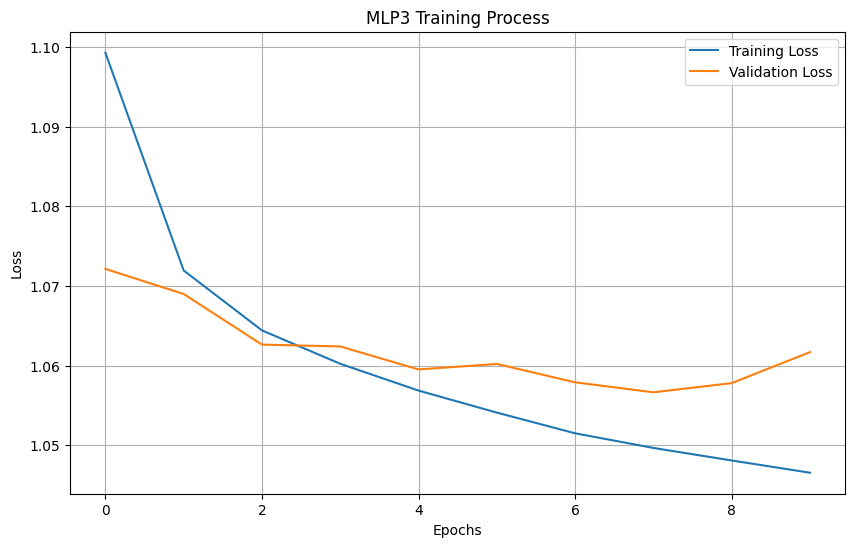

Accuracy: 0.5330820416169852

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.66      0.67     25997
           1       0.46      0.48      0.47     26000
           2       0.43      0.51      0.47     26000
           3       0.47      0.36      0.41     26000
           4       0.64      0.66      0.65     25998

    accuracy                           0.53    129995
   macro avg       0.54      0.53      0.53    129995
weighted avg       0.54      0.53      0.53    129995



In [60]:
# MLP3 Model (2 layers ant tanh, 0.005 LR)
class MLP3(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP3, self).__init__()
        self.model = nn.Sequential(
    nn.Linear(input_dim, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, output_dim)
)

    def forward(self, x):
        return self.model(x)

#model initialization
input_dim = X_train_scaled.shape[1]
output_dim = 5

model3 = MLP3(input_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer3 = optim.Adam(model3.parameters(), lr=0.0005)


# Training Loop
epochs = 10
train_losses_mlp3 = []
val_losses_mlp3 = []

for epoch in range(epochs):
    model3.train()
    running_train_loss = 0.0
    for xb, yb in train_loader:
        optimizer3.zero_grad()
        preds = model3(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer3.step()
        running_train_loss += loss.item() * xb.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses_mlp3.append(epoch_train_loss)

    model3.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for xb_val, yb_val in val_loader:
            val_preds = model3(xb_val)
            val_loss = criterion(val_preds, yb_val)
            running_val_loss += val_loss.item() * xb_val.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses_mlp3.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")


plt.figure(figsize=(10,6))
plt.plot(train_losses_mlp3, label='Training Loss')
plt.plot(val_losses_mlp3, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MLP3 Training Process')
plt.legend()
plt.grid()
plt.show()

#model eval
model3.eval()
with torch.no_grad():
    y_pred_probs = model3(X_val_tensor)
    y_pred = torch.argmax(y_pred_probs, dim=1)

print("Accuracy:", accuracy_score(y_val, y_pred.numpy()))
print("\nClassification Report:\n", classification_report(y_val, y_pred.numpy()))

#Accuracy 53.38%

#Average: precision 53%, recall 53%, f1-score 53%

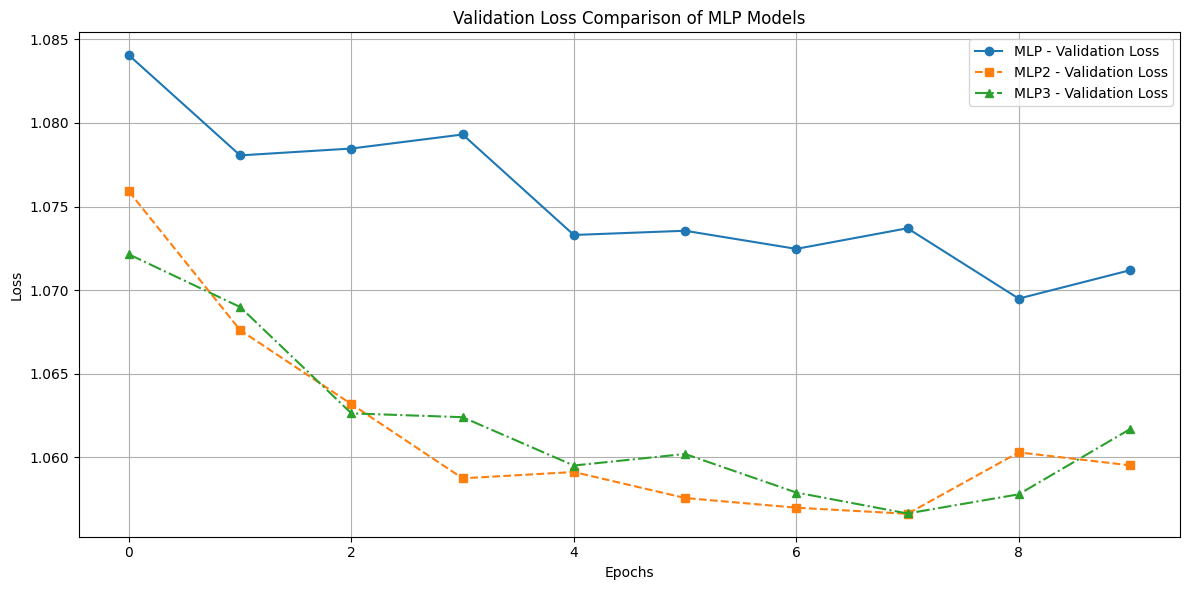

In [61]:
#all together 
plt.figure(figsize=(12, 6))

# Validation Losses
plt.plot(val_losses, label='MLP - Validation Loss', linestyle='-', marker='o')
plt.plot(val_losses_mlp2, label='MLP2 - Validation Loss', linestyle='--', marker='s')
plt.plot(val_losses_mlp3, label='MLP3 - Validation Loss', linestyle='-.', marker='^')


# plt.plot(train_losses, label='MLP - Training Loss', alpha=0.5)
# plt.plot(train_losses_mlp2, label='MLP2 - Training Loss', alpha=0.5)
# plt.plot(train_losses_mlp3, label='MLP3 - Training Loss', alpha=0.5)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss Comparison of MLP Models')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Epoch 1/20 - Train Loss: 1.1654 - Val Loss: 1.0975
Epoch 2/20 - Train Loss: 1.1111 - Val Loss: 1.0854
Epoch 3/20 - Train Loss: 1.1018 - Val Loss: 1.0790
Epoch 4/20 - Train Loss: 1.0962 - Val Loss: 1.0754
Epoch 5/20 - Train Loss: 1.0916 - Val Loss: 1.0724
Epoch 6/20 - Train Loss: 1.0880 - Val Loss: 1.0703
Epoch 7/20 - Train Loss: 1.0857 - Val Loss: 1.0680
Epoch 8/20 - Train Loss: 1.0837 - Val Loss: 1.0664
Epoch 9/20 - Train Loss: 1.0818 - Val Loss: 1.0649
Epoch 10/20 - Train Loss: 1.0797 - Val Loss: 1.0644
Epoch 11/20 - Train Loss: 1.0793 - Val Loss: 1.0630
Epoch 12/20 - Train Loss: 1.0776 - Val Loss: 1.0622
Epoch 13/20 - Train Loss: 1.0764 - Val Loss: 1.0618
Epoch 14/20 - Train Loss: 1.0755 - Val Loss: 1.0611
Epoch 15/20 - Train Loss: 1.0748 - Val Loss: 1.0606
Epoch 16/20 - Train Loss: 1.0739 - Val Loss: 1.0612
Epoch 17/20 - Train Loss: 1.0738 - Val Loss: 1.0596
Epoch 18/20 - Train Loss: 1.0728 - Val Loss: 1.0597
Epoch 19/20 - Train Loss: 1.0722 - Val Loss: 1.0596
Epoch 20/20 - Train L

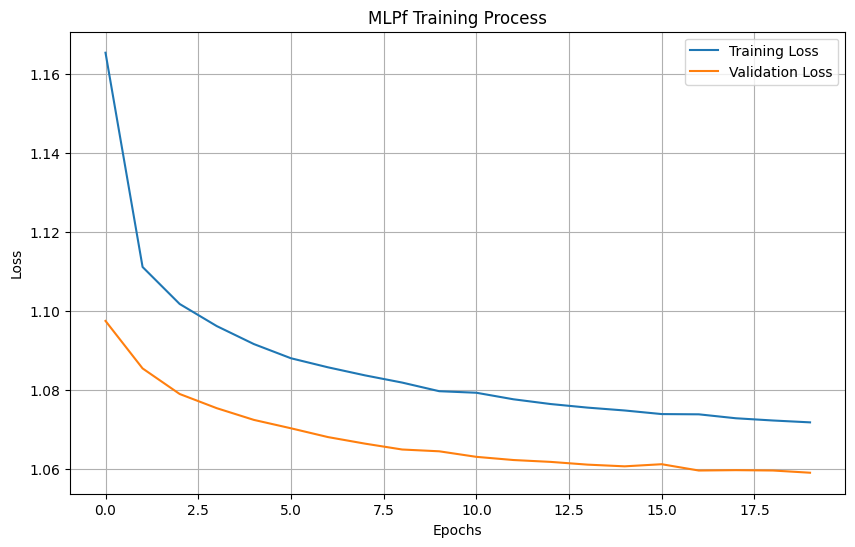

Accuracy: 0.533989768837263

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.73      0.69     25997
           1       0.45      0.46      0.46     26000
           2       0.45      0.41      0.43     26000
           3       0.45      0.46      0.46     26000
           4       0.65      0.62      0.63     25998

    accuracy                           0.53    129995
   macro avg       0.53      0.53      0.53    129995
weighted avg       0.53      0.53      0.53    129995



In [62]:
# MLPf Model (3 layers and ReLU, 0.0001 LR) with Dropout(except in output layer) and L2 Regularization - final model
class MLPf(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_rate=0.2):
        super(MLPf, self).__init__()
        self.model = nn.Sequential(
    nn.Linear(input_dim, 128),
    nn.ReLU(),
    nn.Dropout(dropout_rate),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(dropout_rate),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, output_dim)
)

    def forward(self, x):
        return self.model(x)

#model initialization
input_dim = X_train_scaled.shape[1]
output_dim = 5

modelf = MLPf(input_dim, output_dim)
criterion = nn.CrossEntropyLoss()
weight_decay = 1e-4 #L2 Regularization
optimizerf = optim.Adam(modelf.parameters(), lr=0.0001, weight_decay=weight_decay)


#Training Loop
epochs = 20
train_losses_mlpf = []
val_losses_mlpf = []

for epoch in range(epochs):
    modelf.train()
    running_train_loss = 0.0
    for xb, yb in train_loader:
        optimizerf.zero_grad()
        preds = modelf(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizerf.step()
        running_train_loss += loss.item() * xb.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses_mlpf.append(epoch_train_loss)

    modelf.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for xb_val, yb_val in val_loader:
            val_preds = modelf(xb_val)
            val_loss = criterion(val_preds, yb_val)
            running_val_loss += val_loss.item() * xb_val.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses_mlpf.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")

# Μετά το training, plot:
plt.figure(figsize=(10,6))
plt.plot(train_losses_mlpf, label='Training Loss')
plt.plot(val_losses_mlpf, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MLPf Training Process')
plt.legend()
plt.grid()
plt.show()

#model evaluation
modelf.eval()
with torch.no_grad():
    y_pred_probs = modelf(X_val_tensor)
    y_pred = torch.argmax(y_pred_probs, dim=1)

print("Accuracy:", accuracy_score(y_val, y_pred.numpy()))
print("\nClassification Report:\n", classification_report(y_val, y_pred.numpy()))


#Accuracy 53.48%

#Average: precision 53%, recall 53%, f1-score 53%

In [63]:
#LSTM Neural Network

#load the GloVe embeddings

#glove_path = "/kaggle/input/sotirisbekiaris2/glove.6B.100d.txt" #sotirisbekiaris2/glove-6b-100d

#load  pre-trained embeddings dictionary
def load_glove_embeddings(glove_path):
    embeddings = {}
    with open(glove_path, 'r', encoding='utf8') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vector = np.array(parts[1:], dtype=np.float32)
            embeddings[word] = vector
    return embeddings

glove_path = '/kaggle/input/gloves/glove.6B.100d.txt'
glove_embeddings = load_glove_embeddings(glove_path)


In [64]:
from collections import Counter

all_tokens = [token for tokens in df["tokens"] for token in tokens]
vocab_counter = Counter(all_tokens)
vocab = {word: i+2 for i, (word, _) in enumerate(vocab_counter.items())}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1

# Embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((len(vocab), embedding_dim))

for word, idx in vocab.items():
    if word in glove_embeddings:
        embedding_matrix[idx] = glove_embeddings[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

In [65]:
MAX_LEN = 100

def tokenize(text):
    return text.lower().split()

def encode_text(text):
    tokens = tokenize(text)
    ids = [vocab.get(t, vocab["<UNK>"]) for t in tokens]
    if len(ids) < MAX_LEN:
        ids += [vocab["<PAD>"]] * (MAX_LEN - len(ids))
    else:
        ids = ids[:MAX_LEN]
    return ids

df["input_ids"] = df["text"].apply(encode_text)


In [66]:
from torch.utils.data import Dataset, DataLoader
import torch

X_text_input = df["input_ids"].tolist()
y_sentiment = df["label"].tolist()

class SentimentDatasetAlt(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return {
            "input": torch.tensor(self.inputs[idx], dtype=torch.long),
            "target": torch.tensor(self.targets[idx], dtype=torch.long)
        }

from sklearn.model_selection import train_test_split

X_text_train, X_text_val, y_sentiment_train, y_sentiment_val = train_test_split(
    X_text_input, y_sentiment, test_size=0.2, random_state=42, stratify=y_sentiment
)

train_data_alt = SentimentDatasetAlt(X_text_train, y_sentiment_train)
val_data_alt = SentimentDatasetAlt(X_text_val, y_sentiment_val)

train_loader_alt = DataLoader(train_data_alt, batch_size=32, shuffle=True)
val_loader_alt = DataLoader(val_data_alt, batch_size=32)



In [67]:
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embeddings_matrix, dropout_prob=0.3):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(
            torch.FloatTensor(embeddings_matrix), freeze=False, padding_idx=vocab["<PAD>"]
        )
        self.dropout = nn.Dropout(dropout_prob) #DROPOUT
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x) #DROPOUT after embeddings
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        return out

#model initialization
model = LSTMClassifier(
    vocab_size=len(vocab),
    embedding_dim=100,
    hidden_dim=128,
    output_dim=5,
    embeddings_matrix=embedding_matrix
)


In [68]:
import torch.optim as optim
from tqdm import tqdm

# Training Setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ------------------------------------------
# Training Loop with tqdm

train_losses = []
val_accuracies = []
EPOCHS = 3

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    train_loop = tqdm(train_loader_alt, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch in train_loop:
        inputs = batch["input"].to(device)
        targets = batch["target"].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader_alt)

    # Validation
    model.eval()
    total_correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader_alt:
            inputs = batch["input"].to(device)
            targets = batch["target"].to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == targets).sum().item()
            total += targets.size(0)

    accuracy = total_correct / total
    train_losses.append(avg_train_loss)
    val_accuracies.append(accuracy)
    
    print(f"\nEpoch {epoch+1} - Avg Train Loss: {avg_train_loss:.4f} - Val Accuracy: {accuracy:.4f}\n")


Epoch 1/3: 100%|██████████| 16250/16250 [08:16<00:00, 32.72it/s, loss=0.627]



Epoch 1 - Avg Train Loss: 1.0740 - Val Accuracy: 0.5796



Epoch 2/3: 100%|██████████| 16250/16250 [08:13<00:00, 32.91it/s, loss=1.1]  



Epoch 2 - Avg Train Loss: 0.9238 - Val Accuracy: 0.5920



Epoch 3/3: 100%|██████████| 16250/16250 [08:13<00:00, 32.91it/s, loss=0.752]



Epoch 3 - Avg Train Loss: 0.8582 - Val Accuracy: 0.5932



In [69]:
from sklearn.metrics import classification_report

# Predict on validation set
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in val_loader_alt:
        inputs = batch["input"].to(device)
        targets = batch["target"].to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

print(classification_report(all_targets, all_preds, digits=4))

#Accuracy 59.30%

#Average: precision 59.40%, recall 59.30%, f1-score 59.34%

              precision    recall  f1-score   support

           0     0.7323    0.7028    0.7172     25997
           1     0.5175    0.5701    0.5425     26000
           2     0.5285    0.4898    0.5084     26000
           3     0.5106    0.5062    0.5084     26000
           4     0.6833    0.6972    0.6902     25998

    accuracy                         0.5932    129995
   macro avg     0.5944    0.5932    0.5933    129995
weighted avg     0.5944    0.5932    0.5933    129995



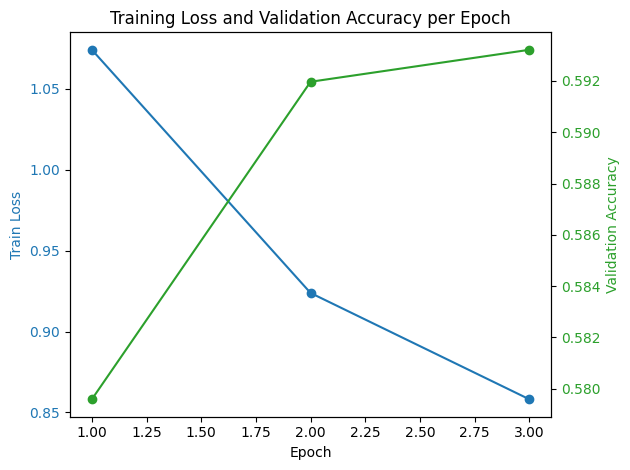

In [70]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

fig, ax1 = plt.subplots()

# Plot training loss
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss', color='tab:blue')
ax1.plot(epochs, train_losses, 'o-', color='tab:blue', label='Train Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for validation accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Validation Accuracy', color='tab:green')
ax2.plot(epochs, val_accuracies, 'o-', color='tab:green', label='Val Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:green')

plt.title('Training Loss and Validation Accuracy per Epoch')
plt.tight_layout()
plt.show()


In [71]:
#Test set transformations
#apply the same functions as in df
def clean_text(text):
    if pd.isna(text):
        return np.nan
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r"[^a-zA-Z' ]+", "", text)
    text = text.lower()
    return text

# Εφαρμογή cleaning
df_test["text"] = df_test["text"].apply(clean_text)

# Πετάμε ό,τι είναι κενό/whitespace/NaN
df_test["text"] = df_test["text"].replace(r'^\s*$', np.nan, regex=True)
df_test = df_test.dropna(subset=["text"])

print(df_test.shape)
df_test[df_test.isnull().any(axis=1)] #null

(49999, 2)


,label,text


In [72]:
#add word_count in df_test
df_test["word_count"] = df_test["text"].apply(lambda x: len(x.split()))
df_test["log_word_count"] = np.log(df_test["word_count"])


In [73]:
#embeddings from Word2Vec

df_test["tokens"] = df_test["text"].str.lower().str.split()
test_embeddings = np.stack([wv.get_mean_vector(tokens) for tokens in df_test["tokens"]])


In [74]:
#X_test and y_test sets
X_test = np.hstack((test_embeddings, df_test[['log_word_count']].values))  # test embeddings + log_word_count
y_test = df_test['label'].values  

X_test_scaled = scaler.transform(X_test)


Test Set Accuracy: 0.46988939778795574

Test Set Classification Report:
               precision    recall  f1-score   support

           0     0.4450    0.8960    0.5947      9999
           1     0.4148    0.1975    0.2676     10000
           2     0.4573    0.2450    0.3191     10000
           3     0.4540    0.2832    0.3488     10000
           4     0.5387    0.7278    0.6191     10000

    accuracy                         0.4699     49999
   macro avg     0.4620    0.4699    0.4299     49999
weighted avg     0.4620    0.4699    0.4299     49999


Test Set ROC-AUC (Macro): 0.8030642497386318


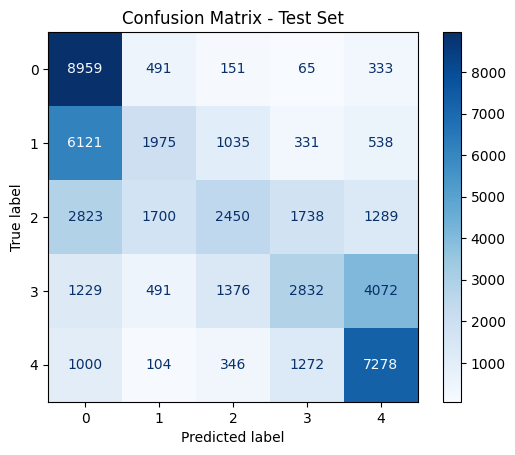

In [75]:
#Multinomial test set
from sklearn.metrics import ConfusionMatrixDisplay

#test set prediction
y_test_pred = best_model.predict(X_test_scaled)

#evaluation
print("Test Set Accuracy:", accuracy_score(df_test['label'], y_test_pred))
print("\nTest Set Classification Report:\n", classification_report(df_test['label'], y_test_pred, digits=4))

#ROC-AUC
y_test_proba = best_model.predict_proba(X_test_scaled)
roc_auc_test = roc_auc_score(df_test['label'], y_test_proba, multi_class='ovr', average='macro')
print("\nTest Set ROC-AUC (Macro):", roc_auc_test)

#Confusion Matrix
cm = confusion_matrix(df_test['label'], y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.show()

#Test set accuracy: 46.81%
#Average: precision 46.11%, recall 46.82%, f1-score 46.81%

Test Set Accuracy: 0.38322766455329105

Test Set Classification Report:
               precision    recall  f1-score   support

           0     0.4858    0.6182    0.5440      9999
           1     0.2962    0.4753    0.3650     10000
           2     0.3258    0.2626    0.2908     10000
           3     0.3714    0.2411    0.2924     10000
           4     0.4778    0.3190    0.3826     10000

    accuracy                         0.3832     49999
   macro avg     0.3914    0.3832    0.3750     49999
weighted avg     0.3914    0.3832    0.3749     49999


Test Set ROC-AUC (Macro): 0.7154392836533898


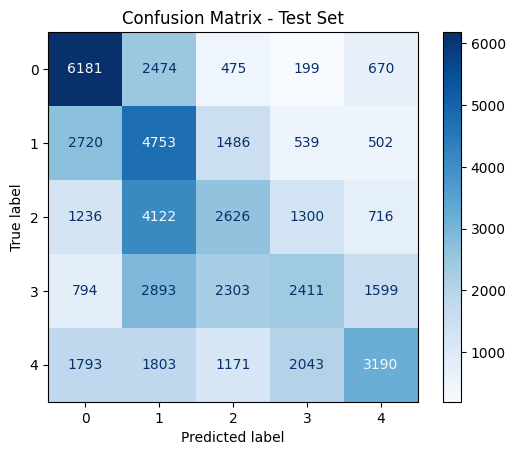

In [76]:
#Naive Bayes Test set

#test set prediction
y_test_pred = gnb_best.predict(X_test_scaled)

#evaluation
print("Test Set Accuracy:", accuracy_score(df_test['label'], y_test_pred))
print("\nTest Set Classification Report:\n", classification_report(df_test['label'], y_test_pred, digits=4))

#ROC-AUC
y_test_proba = gnb_best.predict_proba(X_test_scaled)
roc_auc_test = roc_auc_score(df_test['label'], y_test_proba, multi_class='ovr', average='macro')
print("\nTest Set ROC-AUC (Macro):", roc_auc_test)

#Confusion Matrix
cm = confusion_matrix(df_test['label'], y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.show()

#Test set accuracy: 38.04%
#Average: precision 38.62%, recall 38.05%, f1-score 37.18%

Test Set Accuracy: 0.43896877937558754

Test Set Classification Report:
               precision    recall  f1-score   support

           0     0.5918    0.5785    0.5851      9999
           1     0.3574    0.3724    0.3647     10000
           2     0.3412    0.3504    0.3457     10000
           3     0.3698    0.3711    0.3705     10000
           4     0.5499    0.5225    0.5359     10000

    accuracy                         0.4390     49999
   macro avg     0.4420    0.4390    0.4404     49999
weighted avg     0.4420    0.4390    0.4404     49999


Test Set ROC-AUC (Macro): 0.7520501890326848


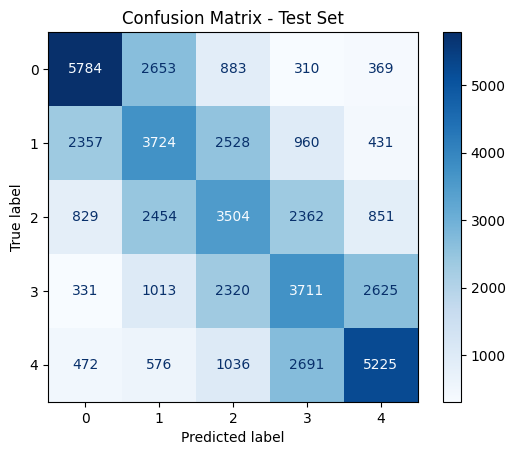

In [77]:
#KNN Test set

#test set prediction
y_test_pred = best_knn.predict(X_test_scaled)

#evaluation
print("Test Set Accuracy:", accuracy_score(df_test['label'], y_test_pred))
print("\nTest Set Classification Report:\n", classification_report(df_test['label'], y_test_pred, digits=4))

#ROC-AUC
y_test_proba = best_knn.predict_proba(X_test_scaled)
roc_auc_test = roc_auc_score(df_test['label'], y_test_proba, multi_class='ovr', average='macro')
print("\nTest Set ROC-AUC (Macro):", roc_auc_test)

#Confusion Matrix
cm = confusion_matrix(df_test['label'], y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.show()

#Test set accuracy: 43.74%
#Average: precision 44.06%, recall 43.75%, f1-score 43.74%

In [78]:
#SVM train with ovr - this model is used in test set

from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score
import numpy as np

#grid search 
param_grid = {
    'estimator__C': [0.01, 0.1, 1, 10],
    'estimator__tol': [1e-4, 1e-3],
    'estimator__max_iter': [3000, 5000],
}

#wrap LinearSVC to OneVsRestClassifier
base_svc = LinearSVC(dual=False, random_state=42)
ovr_svc = OneVsRestClassifier(base_svc)

# GridSearch με OneVsRestClassifier
grid_search = GridSearchCV(
    ovr_svc, param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1
)

grid_search.fit(X_train_scaled, y_train)
print("Best Parameters:", grid_search.best_params_)

#best model
best_svc_ovr = grid_search.best_estimator_

#predictions
y_pred = best_svc_ovr.predict(X_val_scaled)

#evaluation
print("Accuracy:", accuracy_score(y_val, y_pred))
print("F1 Score (macro):", f1_score(y_val, y_pred, average='macro'))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

# ROC-AUC
y_val_bin = label_binarize(y_val, classes=np.unique(y_val))
y_scores = best_svc_ovr.decision_function(X_val_scaled)
roc_auc = roc_auc_score(y_val_bin, y_scores, average='macro', multi_class='ovr')
print("ROC AUC (macro):", roc_auc)


#Average ROC-AUC Score: 80.36%


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters: {'estimator__C': 1, 'estimator__max_iter': 3000, 'estimator__tol': 0.0001}
Accuracy: 0.5036809108042617
F1 Score (macro): 0.4867550872318578

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.79      0.65     25997
           1       0.45      0.33      0.38     26000
           2       0.43      0.37      0.40     26000
           3       0.45      0.34      0.39     26000
           4       0.56      0.69      0.62     25998

    accuracy                           0.50    129995
   macro avg       0.49      0.50      0.49    129995
weighted avg       0.49      0.50      0.49    129995

ROC AUC (macro): 0.804367036630359


Test Set Accuracy: 0.50435008700174

Test Set Classification Report:
               precision    recall  f1-score   support

           0     0.5468    0.7929    0.6473      9999
           1     0.4539    0.3264    0.3797     10000
           2     0.4376    0.3699    0.4009     10000
           3     0.4510    0.3407    0.3882     10000
           4     0.5624    0.6919    0.6205     10000

    accuracy                         0.5044     49999
   macro avg     0.4903    0.5044    0.4873     49999
weighted avg     0.4903    0.5044    0.4873     49999


Test Set ROC-AUC (Macro): 0.8041359217205564


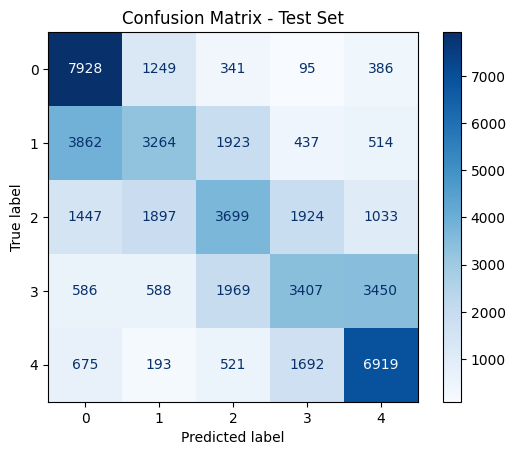

In [79]:
#SVM Test set

##test set prediction
y_test_pred = best_svc_ovr.predict(X_test_scaled)

#evaluation with labels
print("Test Set Accuracy:", accuracy_score(df_test['label'], y_test_pred))
print("\nTest Set Classification Report:\n", classification_report(df_test['label'], y_test_pred, digits=4))

#ROC-AUC with decision_function
y_test_scores = best_svc_ovr.decision_function(X_test_scaled)
y_test_bin = label_binarize(df_test['label'], classes=np.unique(df_test['label']))
roc_auc_test = roc_auc_score(y_test_bin, y_test_scores, multi_class='ovr', average='macro')
print("\nTest Set ROC-AUC (Macro):", roc_auc_test)

#Confusion Matrix
cm = confusion_matrix(df_test['label'], y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.show()

#Test set accuracy: 50.26%
#Average: precision 48.86%, recall 50.26%, f1-score 48.59%

Test Set Accuracy: 0.46988939778795574

Test Set Classification Report:
               precision    recall  f1-score   support

           0     0.4450    0.8960    0.5947      9999
           1     0.4148    0.1975    0.2676     10000
           2     0.4573    0.2450    0.3191     10000
           3     0.4540    0.2832    0.3488     10000
           4     0.5387    0.7278    0.6191     10000

    accuracy                         0.4699     49999
   macro avg     0.4620    0.4699    0.4299     49999
weighted avg     0.4620    0.4699    0.4299     49999


Test Set ROC-AUC (Macro): 0.8030642497386318


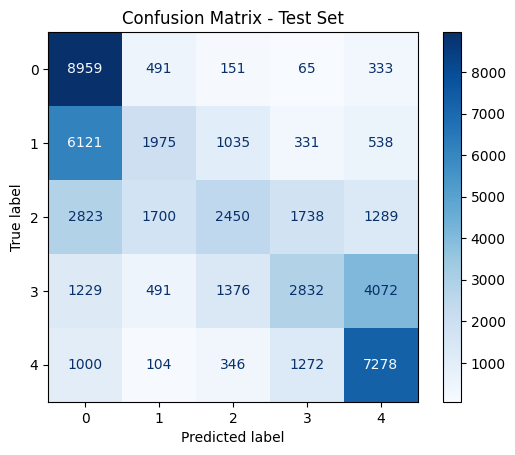

In [80]:
#MLPf Test set

#test set prediction
y_test_pred = best_model.predict(X_test_scaled)

#evaluation
print("Test Set Accuracy:", accuracy_score(df_test['label'], y_test_pred))
print("\nTest Set Classification Report:\n", classification_report(df_test['label'], y_test_pred, digits=4))

#ROC-AUC
y_test_proba = best_model.predict_proba(X_test_scaled)
roc_auc_test = roc_auc_score(df_test['label'], y_test_proba, multi_class='ovr', average='macro')
print("\nTest Set ROC-AUC (Macro):", roc_auc_test)

#Confusion Matrix
cm = confusion_matrix(df_test['label'], y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.show()

#Test set accuracy: 46.85%
#Average: precision 46.13%, recall 46.86%, f1-score 42.86%

Test Accuracy: 0.5915918318366368

Classification Report:
               precision    recall  f1-score   support

           0     0.6967    0.7239    0.7100      9999
           1     0.5118    0.5507    0.5305     10000
           2     0.5283    0.4730    0.4991     10000
           3     0.5204    0.5209    0.5207     10000
           4     0.6974    0.6895    0.6934     10000

    accuracy                         0.5916     49999
   macro avg     0.5909    0.5916    0.5908     49999
weighted avg     0.5909    0.5916    0.5907     49999



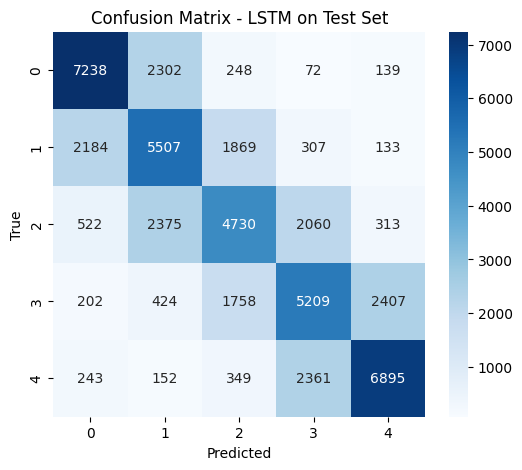

In [81]:
#LSTM Test set

df_test["input_ids"] = df_test["text"].apply(encode_text)

#dataset and dataloader
X_test_input = df_test["input_ids"].tolist()
y_test_labels = df_test["label"].tolist()

test_data = SentimentDatasetAlt(X_test_input, y_test_labels)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

#lstm predictions
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        inputs = batch["input"].to(device)
        targets = batch["target"].to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

#model evaluation
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Test Accuracy:", accuracy_score(all_targets, all_preds))
print("\nClassification Report:\n", classification_report(all_targets, all_preds, digits=4))

#Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - LSTM on Test Set")
plt.show()


#Test set accuracy: 58.88%
#Average: precision 59.20%, recall 58.89%, f1-score 58.89%